In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import ScalarFormatter
# from sklearn.linear_model import RANSACRegressor

from glob import glob
from dataclasses import dataclass

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

## Load

In [3]:
data = load("250321-exp7")

/Users/matteov/Developer/lab3/05-milieux-granulaires/analyse/lib.py:29: UserWarning: loadtxt: input contained no data: "../data/250321-exp7/250321-exp7_step11.txt"
  freq, psd, chi_abs, chi_im = np.loadtxt(file, skiprows=1, delimiter='\t', unpack=True)


## Analysis

### Processed data arrays

In [4]:
noise = data[-1]
clean_psd = []
clean_chi_im = []
averaged_psd = []
averaged_chi_im = []
kB_Teff = []
Teff = []
avg_kB_Teff = []


### Noise removal and filtering

In [5]:
show = False

for i, step in enumerate(data[:-1]):

    # Remove system noise from spectra
    clean_psd.append(step.psd / noise.psd)
    # clean_chi_im.append(step.chi_im / noise.chi_im)
    clean_chi_im.append(step.chi_im)

    # Moving average filter
    window_size = 10
    averaged_psd.append(moving_average(clean_psd[i], window_size))
    averaged_chi_im.append(moving_average(clean_chi_im[i], window_size))

    if (show): # Plot results
        print(step.filename)
        plt.loglog(step.freqs, clean_psd[i])
        plt.loglog(step.freqs, averaged_psd[i])

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ScalarFormatter())
        plt.xticks([5,10,20,30,40,50,60,70])
        plt.xlabel("$f$ [Hz]")
        plt.ylabel("$S$")
        plt.show()


        plt.loglog(step.freqs, clean_chi_im[i])
        plt.loglog(step.freqs, averaged_chi_im[i])

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ScalarFormatter())
        plt.xticks([5,10,20,30,40,50,60,70])
        plt.xlabel("$f$ [Hz]")
        plt.ylabel("Im $\\chi$")
        plt.show()


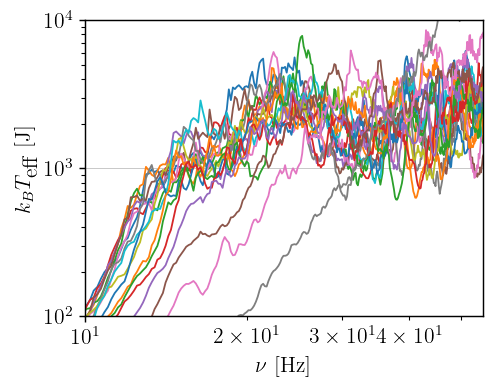

In [6]:
for i, step in enumerate(data[:-1]):
    kB_Teff.append((averaged_psd[i] * 2*np.pi*step.freqs) / (4 *averaged_chi_im[i]))
    Teff.append(kB_Teff[i]/ BOLTZMANN_CONSTANT_JOULE)

    avg_kB_Teff.append(np.mean(kB_Teff[i]))
    plt.loglog(step.freqs, kB_Teff[i])
    plt.xlim(10,55)
    plt.ylim(1e2, 1e4)
    plt.xlabel(r"$\nu$ [Hz]")
    plt.ylabel(r"$k_B T_\textrm{eff}$ [J]")



[-0.29658401  7.7510684 ]


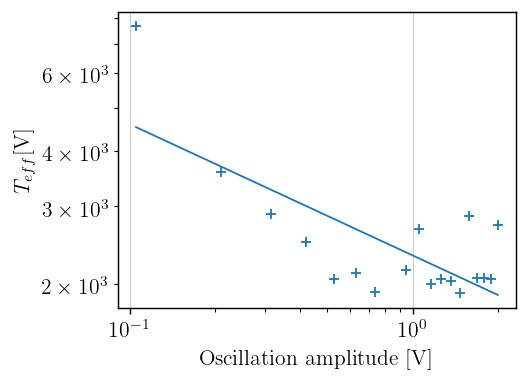

In [9]:
amplitudes = np.array([step.imposed_vibration for step in data[:-1]])
plt.scatter(amplitudes, avg_kB_Teff)

# Weighted fit
xx = np.linspace(min(amplitudes), max(amplitudes), 50)

coefs, cov = np.polyfit(np.log(amplitudes), np.log(avg_kB_Teff), 1, cov=True)
yy = np.polyval(coefs, np.log(xx))
plt.plot((xx), np.exp(yy))
print(coefs)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Oscillation amplitude [V]")
plt.ylabel("$T_{eff}$[V]")

plt.show()
